In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import seaborn as sns
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import random
random.seed(123)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import numpy as np  #to run array operations
import matplotlib.pyplot as plt   # to plot the or to show the images
import os    #to iterate throgh directories
import cv2 
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
K.image_data_format()

'channels_last'

In [3]:
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tqdm import tqdm

In [ ]:
train_path = 'E:/oct images/OCT2017_/train'
CATEGORIES = ["CNV","DME","DRUSEN","NORMAL"]
IMG_SIZE = 128
myList = os.listdir(train_path)

In [ ]:
X=[]
y=[]
for x in myList:
  myPicList = os.listdir(train_path+"/"+str(x))
  for i in tqdm(myPicList):
    curImg = cv2.imread(train_path+"/"+str(x)+"/"+i)
    curImg = cv2.resize(curImg,(IMG_SIZE,IMG_SIZE))
    X.append(curImg)
    y.append(CATEGORIES.index(x))

In [ ]:
X = np.array(X)

In [ ]:
y = np.array(y)

In [ ]:
pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [4]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 4)

### Densenet169 Architecture

In [ ]:
dense_net_169 = tf.keras.applications.DenseNet169(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = None,
    input_shape = (128,128,3), 
    pooling = None, 
    classes = 1000
)

In [ ]:
dense_net_169.trainable = False

In [ ]:
dense_model = tf.keras.models.Sequential([
    
    dense_net_169,
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [ ]:
learning_rate = 0.0001
opt = Adam(lr = learning_rate) 
dense_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

In [ ]:
hist = dense_model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 2, validation_split = 0.2)

### EfficientNetV2 Architecture

In [4]:
import os
import sys
import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore')

D:\Dhanush\Anaconda\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
# SET LIBRARY DIRECTORY
LIB_DIR = "E:/oct images"

# To give access to automl files
sys.path.insert(0, LIB_DIR)
sys.path.insert(0, os.path.join(LIB_DIR, "automl-master"))
sys.path.insert(0, os.path.join(LIB_DIR, "automl-master", "efficientnetv2"))

In [6]:
# EfficientDET Module Imports
import effnetv2_configs
import preprocessing
import effnetv2_model
import hparams
import utils

In [7]:
enetV2_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[128, 128, 3]),
    effnetv2_model.get_model('efficientnetv2-b0', include_top=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [ ]:
# pip install tensorflow_addons

In [ ]:
len(X_train)

In [8]:
enetV2_model.load_weights('weights.hdf5')

In [ ]:
enetV2_model.summary()

In [9]:
learning_rate = 0.0001
opt = Adam(lr = learning_rate) 
enetV2_model.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

In [11]:
checkpoint_filepath = 'weights.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.

In [12]:
# initialize the number of epochs and batch size
EPOCHS = 3
BS = 100
# construct the training image generator for data augmentation
aug = ImageDataGenerator()
# train the network
for i in range(0,5):
    history = enetV2_model.fit_generator(aug.flow(X_train[i*10000:(i+1)*10000], y_train[i*10000:(i+1)*10000], batch_size=BS),
                        validation_data=(X_test, y_test),
                        steps_per_epoch=len(X_train[:10000]) // BS,
                        epochs=EPOCHS,
                        verbose = 1,callbacks=[model_checkpoint_callback])
    print(" ---- ")
    

Epoch 1/3
100/100 [==============================] - 828s 8s/step - loss: 1.0844 - accuracy: 0.5375 - val_loss: 0.4578 - val_accuracy: 0.8471
Epoch 2/3
100/100 [==============================] - 777s 8s/step - loss: 0.4101 - accuracy: 0.8564 - val_loss: 0.3081 - val_accuracy: 0.8924
Epoch 3/3
100/100 [==============================] - 800s 8s/step - loss: 0.2457 - accuracy: 0.9222 - val_loss: 0.2682 - val_accuracy: 0.9080
 ---- 
Epoch 1/3
100/100 [==============================] - 863s 9s/step - loss: 0.2806 - accuracy: 0.9048 - val_loss: 0.2291 - val_accuracy: 0.9216
Epoch 2/3
100/100 [==============================] - 800s 8s/step - loss: 0.1802 - accuracy: 0.9403 - val_loss: 0.2184 - val_accuracy: 0.9261
Epoch 3/3
100/100 [==============================] - 940s 9s/step - loss: 0.1376 - accuracy: 0.9509 - val_loss: 0.2181 - val_accuracy: 0.9279
 ---- 
Epoch 1/3
100/100 [==============================] - 966s 10s/step - loss: 0.2455 - accuracy: 0.9204 - val_loss: 0.1965 - val_accuracy

In [ ]:
hist = enetV2_model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 2, validation_split = 0.2)

In [29]:
# save:
# f = open('history.pckl', 'wb')
# pickle.dump(history, f)
# f.close()

# retrieve:    
f = open('history.pckl', 'rb')
history = pickle.load(f)
f.close()

EOFError: Ran out of input

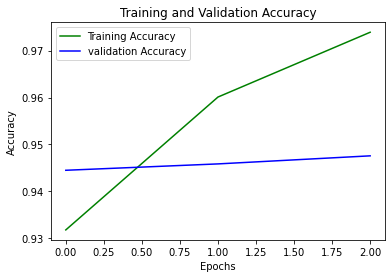

In [32]:
loss_train = history['accuracy']
loss_val = history['val_accuracy']
epochs = range(0,3)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
print(history)

{'loss': [0.195919007062912, 0.11493249237537384, 0.07999210059642792], 'accuracy': [0.9318000078201294, 0.960099995136261, 0.9739000201225281], 'val_loss': [0.16511447727680206, 0.16200970113277435, 0.1653805375099182], 'val_accuracy': [0.9445021152496338, 0.9458596110343933, 0.9475764632225037]}


In [30]:
#print(enetV2_model.keys())
history = {'loss': [0.195919007062912, 0.11493249237537384, 0.07999210059642792], 'accuracy': [0.9318000078201294, 0.960099995136261, 0.9739000201225281], 'val_loss': [0.16511447727680206, 0.16200970113277435, 0.1653805375099182], 'val_accuracy': [0.9445021152496338, 0.9458596110343933, 0.9475764632225037]}

### EfficientNetB2 Architecture

In [ ]:
# pip install tf-nightly

In [ ]:
# !pip install -q efficientnet

In [ ]:
import efficientnet.tfkeras as efc

In [ ]:
enet_b2 = efc.EfficientNetB2(input_shape=(128,128,3),
                                include_top=False, 
                                weights='imagenet',
                               )

In [ ]:
#enet_b2.summary()

In [ ]:
learning_rate = 0.0001
opt = Adam(lr = learning_rate) 
enet_b2.compile(optimizer = opt, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )

In [ ]:
hist = enet_b2.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 2, validation_split = 0.2)

### Model Testing

In [ ]:
train_results_d = dense_model.evaluate(X_test, y_test)
print("test loss, test acc:", train_results)

In [ ]:
train_results_eb2 = enet_b2.evaluate(X_test, y_test)
print("test loss, test acc:", train_results)

In [22]:
train_results_ev2 = enetV2_model.evaluate(X_test, y_test)
print("test loss, test acc:", train_results_ev2)

783/783 [==============================] - 284s 362ms/step - loss: 0.1654 - accuracy: 0.9476
test loss, test acc: [0.1653805375099182, 0.9475764632225037]


### Testing with test Dataset

In [11]:
test_path = 'E:/oct images/OCT2017_/test'
CATEGORIES = ["CNV","DME","DRUSEN","NORMAL"]
IMG_SIZE = 128
myTestList = os.listdir(test_path)

In [12]:
from tqdm import tqdm
A=[]
b=[]
for x in myTestList:
  myPicList = os.listdir(test_path+"/"+str(x))
  for i in tqdm(myPicList):
    curImg = cv2.imread(test_path+"/"+str(x)+"/"+i)
    curImg = cv2.resize(curImg,(IMG_SIZE,IMG_SIZE))
    A.append(curImg)
    b.append(CATEGORIES.index(x))

100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [00:05<00:00, 44.05it/s]


In [13]:
A = np.array(A)
b = np.array(b)

In [ ]:
len(A)//31

In [14]:
test_results = model.evaluate(A, b)
print("test loss, test acc:", test_results)

NameError: name 'model' is not defined

In [ ]:
test_results = model.evaluate(A, b)
print("test loss, test acc:", test_results)

In [15]:
test_results_enetV2 = enetV2_model.evaluate(A, b)
print("test loss, test acc:", test_results_enetV2)

31/31 [==============================] - 23s 391ms/step - loss: 0.0459 - accuracy: 0.9777
test loss, test acc: [0.06786005944013596, 0.9690082669258118]


In [16]:
D_test = enetV2_model.predict(A)
D_test = np.argmax(D_test,axis=1)

In [19]:
from sklearn.metrics import f1_score
f_score = f1_score(b, D_test, average=None)
for i in range(4):
    print(str(CATEGORIES[i])+" F1 Score : "+str(f_score[i]))

CNV F1 Score : 0.9506903353057199
DME F1 Score : 0.9790794979079498
DRUSEN F1 Score : 0.9570815450643777
NORMAL F1 Score : 0.9896907216494846


In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
cf_matrix = confusion_matrix(b,D_test)
print(cf_matrix)

[[241   1   0   0]
 [  6 234   0   2]
 [ 18   0 223   1]
 [  0   1   1 240]]


<AxesSubplot:>

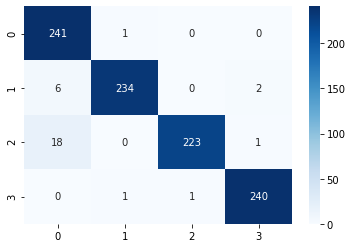

In [27]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True,cmap='Blues',fmt = 'd')

### Testing with Validation Dataset

In [28]:
val_path = 'E:/oct images/OCT2017_/val'
CATEGORIES = ["CNV","DME","DRUSEN","NORMAL"]
IMG_SIZE = 128
myvalList = os.listdir(val_path)

In [29]:
from tqdm import tqdm
P=[]
q=[]
for x in myvalList:
  myPicList = os.listdir(val_path+"/"+str(x))
  for i in tqdm(myPicList):
    curImg = cv2.imread(val_path+"/"+str(x)+"/"+i)
    curImg = cv2.resize(curImg,(IMG_SIZE,IMG_SIZE))
    P.append(curImg)
    q.append(CATEGORIES.index(x))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.78it/s]


In [30]:
P = np.array(P)
q = np.array(q)

In [ ]:
P.shape

In [ ]:
val_results = dense_model.evaluate(P, q)
print("test loss, test acc:", val_results)

In [ ]:
val_results = enet_B2.evaluate(P, q)
print("test loss, test acc:", val_results)

In [31]:
val_results_enetV2 = enetV2_model.evaluate(P, q)
print("test loss, test acc:", val_results_enetV2)

1/1 [==============================] - 3s 3s/step - loss: 0.0076 - accuracy: 1.0000
test loss, test acc: [0.007550552953034639, 1.0]


In [ ]:
D = enetV2_model.predict(P)
D = np.argmax(D,axis=1)

In [ ]:
cnt = 0
for i in range(len(D)):
    if D[i] == q[i]:
        cnt+=1
print(cnt)

In [ ]:
D_test = enetV2_model.predict(A)
D_test = np.argmax(D_test,axis=1)

In [ ]:
cnt_test = 0
for i in range(len(D_test)):
    if D_test[i] == b[i]:
        cnt_test+=1
print((cnt_test/len(D_test))*100)